In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="7"


import random
import numpy as np
import seaborn as sns
import pickle
import matplotlib
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch
import swifter
from torch import nn, Tensor
from torch.autograd import Variable
import pandas as pd
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import KBinsDiscretizer
from torch.optim import Adam, lr_scheduler
from torch.nn import BCEWithLogitsLoss
from torchinfo import summary
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from mlflow import MlflowClient
import mlflow

/tmp/ipykernel_3447928/3352359748.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
class MLFlowLogger:
    def __init__(self,exp_name,
                 config:dict,
                 tracking_url:str = "http://127.0.0.1:5000",
                 ) -> None:
        
        self.client = MlflowClient(tracking_uri=tracking_url)
        self._experiment = mlflow.set_experiment(
            exp_name
        )
        
        with mlflow.start_run() as run:
            self.run_info = run.info
        
        self.track_params(config=config)
        
    
    def track_params(self, config:dict):
        params = MLFlowLogger.unnest_dictionary(config)
        
        with mlflow.start_run(run_id=self.run_info.run_id) as run:
            if not self.run_info:
                self.run_info = run.info
            
            mlflow.log_params(params)
        
        
    def track_metrics(self, metrics:dict):
        params = MLFlowLogger.unnest_dictionary(metrics)
        
        with mlflow.start_run(run_id=self.run_info.run_id) as run:
            if not self.run_info:
                self.run_info = run.info
            
            mlflow.log_metrics(metrics)
        
    
    @staticmethod
    def unnest_dictionary(d:dict, level:str=None, unnested_dict:dict = {}) -> dict:
        for k, v in d.items():
            if level:
                next_level=f"{level}_{k}"
            else:
                next_level = k
                
            if not isinstance(v,dict):
                #print(level,k)
                unnested_dict[next_level] = v
            else:
                #print(d,level,k,v,2)
                MLFlowLogger.unnest_dictionary(v, next_level, unnested_dict)
                
        return unnested_dict

In [4]:
#config of run

config = {
    "dataset":{
        "name":'Drug_Drug_interaction_agent',
        "encoding":"proteinbert",
        "data_loc": "processed_data",
        'model_checkpoint': "facebook/esm2_t6_8M_UR50D",
    },
    "model":{
        "max_length_tokens": 300,
        'input_dim_Drug': 320,
        'input_dim_Target': 320,
        'n_Drug_channels': 320,
        'n_Target_channels': 320,
        'hidden_dim_Drug': 256,
        'hidden_dim_Target': 256,
        'result_folder': './result/',
        },
    
    "optimizer":{
        'LR': 0.01,
        "weight_decay":1e-5
    },
    'batch_size': 128,
    'train_epoch': 20,
    "device": "cuda",
    "seed": 49
}

#set seeds
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

#device
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#mlflow
run_tracker = MLFlowLogger(
    f"{config['dataset']['name']}_{config['dataset']['encoding']}",
    config)

In [5]:
def get_esm2_components(config,device):

    model_checkpoint = config["dataset"]['model_checkpoint']

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    esm2_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint).to(device)
    
    return tokenizer, esm2_model

tokenizer, esm2_model = get_esm2_components(config,device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
tokenizer

EsmTokenizer(name_or_path='facebook/esm2_t6_8M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
esm2_model.to(device)
esm2_model.esm.embeddings

EsmEmbeddings(
  (word_embeddings): Embedding(33, 320, padding_idx=1)
  (dropout): Dropout(p=0.0, inplace=False)
  (position_embeddings): Embedding(1026, 320, padding_idx=1)
)

In [8]:
train_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/train.csv")
valid_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/valid.csv")
test_dataset = pd.read_csv(f"{config['dataset']['data_loc']}/test.csv")

In [9]:
_l = pd.Series(train_dataset.loc[:,"Drug"].unique()).str.len()
_l.min(), _l.max()

(1, 1013)

<Axes: >

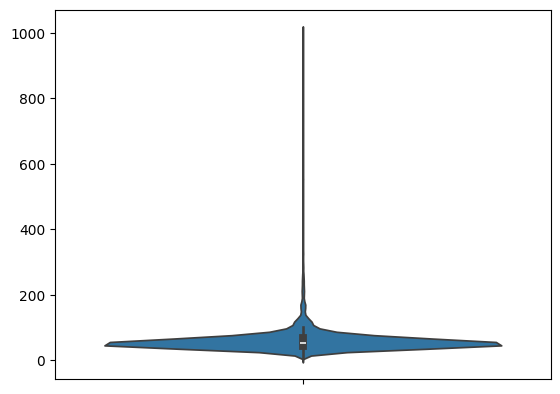

In [10]:
sns.violinplot(_l)

<Axes: >

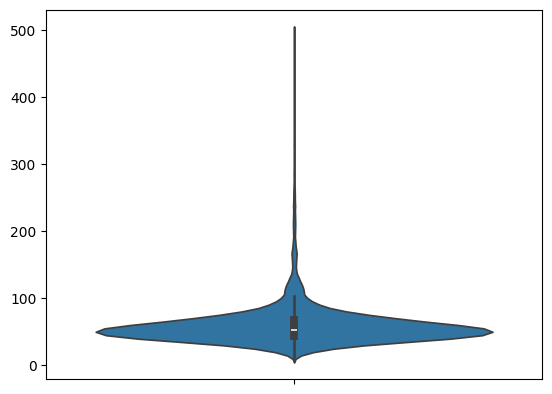

In [11]:
sns.violinplot(_l[(10<=_l)&(_l<=500)])

In [12]:
_l = pd.Series(train_dataset.loc[:,"Target"].unique()).str.len()
_l.min(), _l.max()

(7, 7073)

<Axes: >

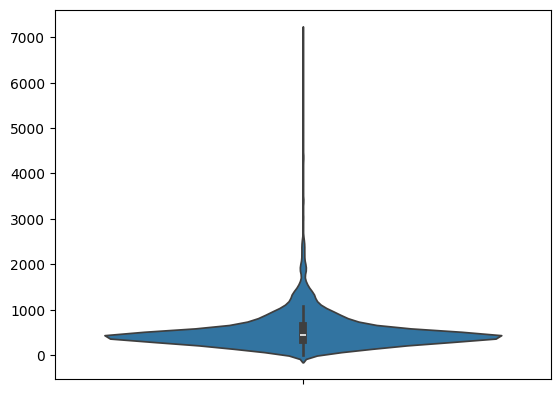

In [13]:
sns.violinplot(_l)

<Axes: >

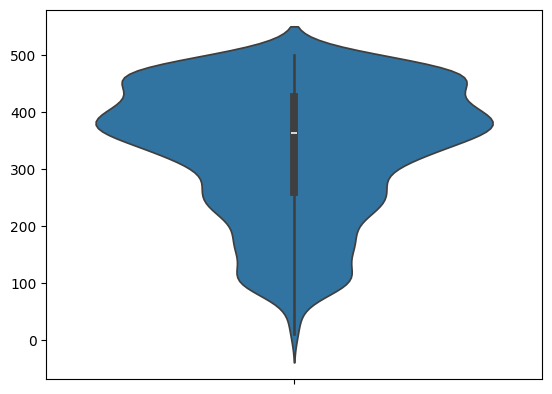

In [14]:
sns.violinplot(_l[(10<=_l)&(_l<=500)])

In [15]:
max_seq_drug = 500

train_dataset = train_dataset[(train_dataset.Drug.str.len()<=max_seq_drug)&(train_dataset.Target.str.len()<=max_seq_drug)]
valid_dataset = valid_dataset[(valid_dataset.Drug.str.len()<=max_seq_drug)&(valid_dataset.Target.str.len()<=max_seq_drug)]
test_dataset = test_dataset[(test_dataset.Drug.str.len()<=max_seq_drug)&(test_dataset.Target.str.len()<=max_seq_drug)]

config["model"]["max_seq_Drug"] = max_seq_drug
config["model"]["max_seq_Target"] = max_seq_drug


In [16]:
(train_dataset.shape,
 valid_dataset.shape,
 test_dataset.shape,
 )

((207451, 6), (31338, 6), (62139, 6))

In [17]:
def esm2_tokernized_encoding_drug(dataset):
    unique_drug = dataset["Drug"].unique().tolist()+ dataset["Target"].unique().tolist()
    unique_Drug_tokens = tokenizer(
        unique_drug,
        padding='max_length',
        max_length=config['model']['max_length_tokens'],
        truncation=True
        )
    
    unique_dict_input_ids = dict(zip(unique_drug, unique_Drug_tokens["input_ids"]))
    unique_dict_attention_mask = dict(zip(unique_drug, unique_Drug_tokens["attention_mask"]))
    
    Drug_enc_input_ids = dataset["Drug"].apply(lambda x:unique_dict_input_ids[x]).to_numpy()
    Drug_enc_attention_mask = dataset["Drug"].apply(lambda x:unique_dict_attention_mask[x]).to_numpy()

    Target_enc_input_ids = dataset["Target"].apply(lambda x:unique_dict_input_ids[x]).to_numpy()
    Target_enc_attention_mask = dataset["Target"].apply(lambda x:unique_dict_attention_mask[x]).to_numpy()

    return Drug_enc_input_ids, Drug_enc_attention_mask, Target_enc_input_ids, Target_enc_attention_mask

# Example usage:
train_tokens = esm2_tokernized_encoding_drug(train_dataset)
valid_tokens = esm2_tokernized_encoding_drug(valid_dataset)
test_tokens = esm2_tokernized_encoding_drug(test_dataset)

In [18]:
class DrugTargetDataset(Dataset):
    def __init__(self, 
        ds_name, 
        Drug, 
        Drug_input_ids, 
        Drug_att_mask,  
        Target, 
        Target_input_ids, 
        Target_att_mask,
        y):
        super(DrugTargetDataset, self).__init__()
        self.ds_name = ds_name
        self.Drug = Drug
        self.Drug_input_ids = Drug_input_ids
        self.Drug_att_mask= Drug_att_mask
        self.Target = Target
        self.Target_input_ids = Target_input_ids
        self.Target_att_mask= Target_att_mask
        self.y = y

    def __getitem__(self, ind):
        return (#self.ds_name,
                #self.Drug[ind],
                torch.Tensor(self.Drug_input_ids[ind]), 
                torch.Tensor(self.Drug_att_mask[ind]),
                torch.Tensor(self.Target_input_ids[ind]), 
                torch.Tensor(self.Target_att_mask[ind]),
                self.y[ind])

    def __len__(self):
        return self.Drug_input_ids.shape[0]

### Model Training

In [19]:
def get_multilabel_onehot(labels, max_labels):
    l = np.zeros((len(labels), max_labels))
    for i,label in enumerate(labels):
        l[i,label] = 1
        
    return l

def create_ds_and_dl(_dataset, _tokens):
    
    _dt = DrugTargetDataset(
            _dataset.loc[:,"ds_name"].tolist(),
            _dataset.loc[:,"Drug"].tolist(),
            _tokens[0], 
            _tokens[1], 
            _dataset.loc[:,"Target"].tolist(),
            _tokens[2], 
            _tokens[3],
            _dataset.loc[:,"Y"].tolist(),
        )
    
    _dl = DataLoader(
            _dt, 
            batch_size=config['batch_size'], 
            shuffle=False, 
            pin_memory=True, 
        )
    
    return _dt, _dl

train_dt, train_dl = create_ds_and_dl(train_dataset, train_tokens)
valid_dt, valid_dl = create_ds_and_dl(valid_dataset, valid_tokens)
test_dt, test_dl = create_ds_and_dl(test_dataset, test_tokens)

In [20]:
def embedding_step(dataloader, device, desc="processing"):
    esm2_model.eval()
    step_embeddings_Drug = []
    step_embeddings_Target = []
    #step_ds = []
    y_true = []

    with tqdm(dataloader, unit="batch", desc=desc) as tepoch:
        for batch in tepoch:
            Drug_input_ids, Drug_att_mask,  Target_input_ids, Target_att_mask, y_batch = batch
            
            Drug_input_ids = Drug_input_ids.long().to(device)
            Drug_att_mask = Drug_att_mask.long().to(device)
            
            Target_input_ids = Target_input_ids.long().to(device)
            Target_att_mask = Target_att_mask.long().to(device)
            
            Drug = esm2_model.esm.embeddings(Drug_input_ids, Drug_att_mask)
            Drug = esm2_model.esm.encoder(Drug)
            Drug = Drug.last_hidden_state
            
            Target = esm2_model.esm.embeddings(Target_input_ids, Target_att_mask)
            Target = esm2_model.esm.encoder(Target)
            Target = Target.last_hidden_state
            
            step_embeddings_Drug.append(Drug[:,0,:].detach().cpu().numpy())
            step_embeddings_Target.append(Target[:,0,:].detach().cpu().numpy())
            y_true.append(y_batch.detach().cpu().numpy())

            # convert feature vector into action class

    return (np.concatenate(step_embeddings_Drug, axis=0), 
            np.concatenate(step_embeddings_Target, axis=0), 
            np.concatenate(y_true, axis=0),)
            #np.concatenate(step_ds, axis=0))

In [21]:
#calculate train embeddings
train_embeddings_Drug, train_embeddings_Target, train_y = embedding_step(train_dl, device, desc="train embeddings")

#calculate valid embeddings
valid_embeddings_Drug, valid_embeddings_Target, valid_y = embedding_step(valid_dl, device, desc="valid embeddings")

#calculate test embeddings
test_embeddings_Drug, test_embeddings_Target, test_y = embedding_step(test_dl, device, desc="test embeddings")

train embeddings:   0%|          | 0/1621 [00:00<?, ?batch/s]

valid embeddings:   0%|          | 0/245 [00:00<?, ?batch/s]

test embeddings:   0%|          | 0/486 [00:00<?, ?batch/s]

In [22]:
del esm2_model
del tokenizer
torch.cuda.empty_cache()

In [32]:
def concatenate_embeddings(embeddings_Drug, embeddings_Target, y):
    return np.concatenate([embeddings_Drug, embeddings_Target], axis=1), y

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def unnest_dictionary(d:dict, level:str=None, unnested_dict:dict = {}) -> dict:
    for k, v in d.items():
        if level:
            next_level=f"{level}_{k}"
        else:
            next_level = k
            
        if not isinstance(v,dict):
            #print(level,k)
            unnested_dict[next_level] = v
        else:
            #print(d,level,k,v,2)
            unnest_dictionary(v, next_level, unnested_dict)
            
    return unnested_dict

In [ ]:
train_embeddings, train_y = concatenate_embeddings(train_embeddings_Drug, train_embeddings_Target, train_y)
valid_embeddings, valid_y = concatenate_embeddings(valid_embeddings_Drug, valid_embeddings_Target, valid_y)
test_embeddings, test_y = concatenate_embeddings(test_embeddings_Drug, test_embeddings_Target, test_y)

In [24]:
train_embeddings.shape, train_y.shape

((207451, 640), (207451,))

In [30]:
from xgboost import XGBRegressor

#write a function to evaluate a multi label binary classifier
def evaluate_regression(y, y_pred, ds_name):
    reports = {}
    
    mse = metrics.mean_squared_error(y, y_pred)
    mae = metrics.mean_absolute_error(y, y_pred)
    r2_score = metrics.r2_score(y, y_pred)
    
    reports["whole"] = {
        "mse": mse,
        "mae": mae,
        "r2_score": r2_score}
    
    ds_unique = np.unique(flatten_list(ds_name))
    for ds in ds_unique:
        idx = ds_name.apply(lambda x: ds in x)
        y_ds = y[idx]
        y_pred_ds = y_pred[idx]
        
        mse = metrics.mean_squared_error(y_ds, y_pred_ds)
        mae = metrics.mean_absolute_error(y_ds, y_pred_ds)
        r2_score = metrics.r2_score(y_ds, y_pred_ds)
        
        reports[ds] = {
            "mse": mse,
            "mae": mae,
            "r2_score": r2_score
            }
        
    reports = pd.DataFrame.from_records(reports)
        
    return reports

def save_model(model, save_path):
    import joblib
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(model, save_path)
        
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    device='gpu',
    n_jobs=-1,
    random_state=config["seed"]
    )

xgb_model.fit(train_embeddings, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=49, ...)

In [33]:
valid_preds = xgb_model.predict(valid_embeddings)
evaluate_regression(valid_y, valid_preds, valid_dataset["ds_name"].apply(eval))

,BindingDB_Ki,DAVIS,KIBA,whole
mse,0.920573,0.550290,0.070352,0.799570
mae,0.741280,0.557639,0.160688,0.660283
r2_score,0.577219,-0.019051,-18.862650,0.609352


In [34]:
test_preds = xgb_model.predict(test_embeddings)
evaluate_regression(test_y, test_preds, test_dataset["ds_name"].apply(eval))

,BindingDB_Ki,DAVIS,KIBA,whole
mse,0.917747,0.591542,0.069190,0.796879
mae,0.741467,0.583912,0.160003,0.660241
r2_score,0.575225,-0.062594,-15.343458,0.608151


In [35]:
save_model(xgb_model, f"models/xgb_DTI.pkl")